<a href="https://colab.research.google.com/github/8sheeta8/2025_Capstone_DDoS-Botnet/blob/main/DDoS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np

# 정상 데이터
normal = np.load('/content/normal_combined.npy')
print("✅ normal shape:", normal.shape)

# DDoS 공격 데이터
http = np.load('/content/http_flood.npy')
icmp = np.load('/content/icmp_flood.npy')
tcp_ack = np.load('/content/tcp_ack.npy')
tcp_other = np.load('/content/tcp_other.npy')
udp_other = np.load('/content/udp_other.npy')

# 각각 shape 확인
print("📂 http_flood:", http.shape)
print("📂 icmp_flood:", icmp.shape)
print("📂 tcp_ack:", tcp_ack.shape)
print("📂 tcp_other:", tcp_other.shape)
print("📂 udp_other:", udp_other.shape)


✅ normal shape: (106561, 1024)
📂 http_flood: (378, 500)
📂 icmp_flood: (702, 500)
📂 tcp_ack: (5389, 500)
📂 tcp_other: (5389, 500)
📂 udp_other: (184, 500)


In [3]:


def pad_array(arr, target_len=1024):
    if arr.shape[1] >= target_len:
        return arr[:, :target_len]
    else:
        pad_width = target_len - arr.shape[1]
        return np.pad(arr, ((0, 0), (0, pad_width)), mode='constant')

# 모든 데이터 길이 1024로 맞춤
normal = pad_array(normal)
http = pad_array(http)
icmp = pad_array(icmp)
tcp_ack = pad_array(tcp_ack)
tcp_other = pad_array(tcp_other)
udp_other = pad_array(udp_other)

ddos = np.concatenate([http, icmp, tcp_ack, tcp_other, udp_other], axis=0)
X = np.concatenate([normal, ddos], axis=0)

# 입력과 라벨 생성
y = np.array([0]*len(normal) + [1]*len(ddos))

print("✅ 전체 데이터 shape:", X.shape)
print("✅ 라벨 shape:", y.shape)


✅ 전체 데이터 shape: (118603, 1024)
✅ 라벨 shape: (118603,)


In [4]:
# CNN 입력을 위한 reshape (샘플 수, 특징 수, 채널 수)
X = X.reshape((X.shape[0], X.shape[1], 1))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print("🎯 학습 데이터:", X_train.shape, y_train.shape)
print("🎯 테스트 데이터:", X_test.shape, y_test.shape)


🎯 학습 데이터: (59301, 1024, 1) (59301,)
🎯 테스트 데이터: (59302, 1024, 1) (59302,)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1022, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1022, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 511, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 511, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 509, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 509, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 254, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,080,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,087,745 (7.96 MB)

 Trainable params: 2,087,553 (7.96 MB)

 Non-trainable params: 192 (768.00 B)

In [6]:
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 224s 237ms/step - accuracy: 0.9138 - loss: 0.2678 - val_accuracy: 0.8890 - val_loss: 0.2893
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 256s 232ms/step - accuracy: 0.9383 - loss: 0.1620 - val_accuracy: 0.9160 - val_loss: 0.2094
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 212s 229ms/step - accuracy: 0.9414 - loss: 0.1457 - val_accuracy: 0.9454 - val_loss: 0.1387
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 271s 238ms/step - accuracy: 0.9463 - loss: 0.1339 - val_accuracy: 0.9477 - val_loss: 0.1307
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 255s 230ms/step - accuracy: 0.9487 - loss: 0.1243 - val_accuracy: 0.9496 - val_loss: 0.1253
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 263s 231ms/step - accuracy: 0.9495 - loss: 0.1209 - val_accuracy: 0.9510 - val_loss: 0.1199
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 265s 235ms/step - accuracy: 0.9505 - loss: 0.1205 - val_accuracy: 0.9501 - val_loss: 0.1317
Epoch 8/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 262s 235ms/step - accuracy: 0.9521 -

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

# 평가 출력
print(classification_report(y_test, y_pred_class))
print(confusion_matrix(y_test, y_pred_class))


1854/1854 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     53233
           1       0.96      0.57      0.71      6069

    accuracy                           0.95     59302
   macro avg       0.95      0.78      0.84     59302
weighted avg       0.95      0.95      0.95     59302

[[53077   156]
 [ 2623  3446]]


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# 🔹 데이터 로드

# 🔹 라벨 부여 (0~4: 각각의 DDoS 기법)
labels_ddos = np.array(
    [0]*len(http) + [1]*len(icmp) + [2]*len(tcp_ack) + [3]*len(tcp_other) + [4]*len(udp_other)
)

# 🔹 입력 데이터 합치기
X_2 = np.concatenate([http, icmp, tcp_ack, tcp_other, udp_other], axis=0)
X_2 = X_2.reshape((X_2.shape[0], X_2.shape[1], 1))  # (샘플 수, 1024, 1)

# 🔹 학습 / 테스트 분리
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, labels_ddos, test_size=0.5, random_state=42)


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l1

# 🔹 SSAE 구조 정의
input_dim = X2_train.shape[1]  # ex. 1024
encoding_dim = 128  # 압축할 차원 수
sparsity = 1e-3

input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu', activity_regularizer=l1(sparsity))(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# 🔹 SSAE는 Flatten 된 상태로 학습하므로 reshape
X2_train_flat = X2_train.reshape((X2_train.shape[0], X2_train.shape[1]))
X2_test_flat = X2_test.reshape((X2_test.shape[0], X2_test.shape[1]))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X2_train_flat = scaler.fit_transform(X2_train_flat)
X2_test_flat = scaler.transform(X2_test_flat)

# 🔹 SSAE 학습
history = autoencoder.fit(X2_train_flat, X2_train_flat,
                          epochs=20, batch_size=64,
                          validation_data=(X2_test_flat, X2_test_flat))

# 🔹 Feature vector 추출
X2_train_feat = encoder.predict(X2_train_flat)
X2_test_feat = encoder.predict(X2_test_flat)

# reshape to CNN 입력 형태 (feature_len, 1)
X2_train_feat = X2_train_feat.reshape((X2_train_feat.shape[0], X2_train_feat.shape[1], 1))
X2_test_feat = X2_test_feat.reshape((X2_test_feat.shape[0], X2_test_feat.shape[1], 1))


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.5301 - val_loss: 0.0593
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0595 - val_loss: 0.0588
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0594 - val_loss: 0.0587
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0605 - val_loss: 0.0465
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0456 - val_loss: 0.0416
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0425 - val_loss: 0.0397
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0405 - val_loss: 0.0389
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0390 - val_loss: 0.0382
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0386 - val_loss: 0.0375
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0379 - val_loss: 0.0375
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0383 - val_loss: 0.0368
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.

SSAE 성능 확인

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0361 - val_loss: 0.0359
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0370 - val_loss: 0.0356
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0363 - val_loss: 0.0361
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0381 - val_loss: 0.0360
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0367 - val_loss: 0.0366
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0367 - val_loss: 0.0354
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0363 - val_loss: 0.0354
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0358 - val_loss: 0.0362
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0360 - val_loss: 0.0353
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0365 - val_loss: 0.0357
Epoch 11/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0364 - val_loss: 0.0352
Epoch 12/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


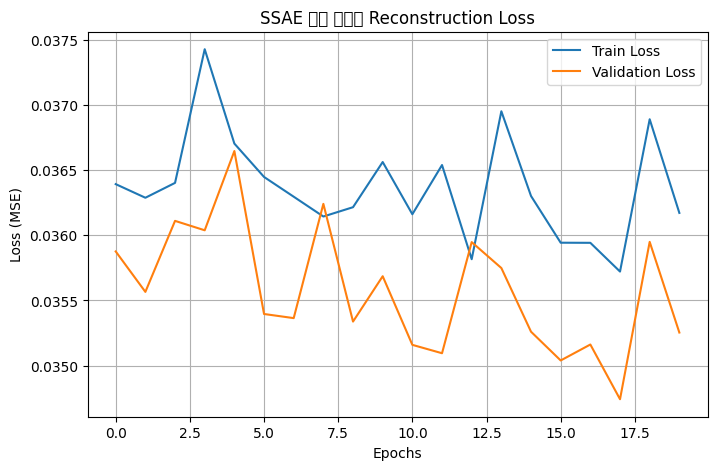

In [14]:
import matplotlib.pyplot as plt

# 🔹 학습 결과 저장하며 훈련 (이전에 했던 코드)
history = autoencoder.fit(X2_train_flat, X2_train_flat,
                          epochs=20, batch_size=64,
                          validation_data=(X2_test_flat, X2_test_flat))

# 🔹 손실 시각화
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('SSAE 학습 과정의 Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()



In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 모델 구성
model_ssae = Sequential([
    Input(shape=(X2_train_feat.shape[1], 1)),  # ✅ 이게 더 안전
    Conv1D(32, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

# ✅ 컴파일 추가 (이걸 안 하면 오류 발생)
model_ssae.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ✅ 조기 종료 콜백
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# ✅ 학습
model_ssae.fit(
    X2_train_feat, y2_train,
    epochs=20,
    batch_size=64,
    validation_data=(X2_test_feat, y2_test),
    callbacks=[early_stop]
)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4455 - loss: 1.4143 - val_accuracy: 0.0595 - val_loss: 1.5577
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4952 - loss: 0.9528 - val_accuracy: 0.0595 - val_loss: 1.5634
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4972 - loss: 0.9096 - val_accuracy: 0.0619 - val_loss: 1.6513
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.4790 - loss: 0.9137 - val_accuracy: 0.0827 - val_loss: 1.5663
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4941 - loss: 0.9013 - val_accuracy: 0.1420 - val_loss: 1.5487
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4919 - loss: 0.9141 - val_accuracy: 0.2629 - val_loss: 1.5384
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4906 - loss: 0.8887 - val_accuracy: 0.2704 - val_loss: 1.2514
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4861 - loss: 0.9039 - val_accuracy: 0.4836 - 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔹 예측
y2_pred_probs = model_2.predict(X2_test)
y2_pred_classes = np.argmax(y2_pred_probs, axis=1)

# 🔹 클래스 이름
attack_labels = ['HTTP Flood', 'ICMP Flood', 'TCP ACK Flood', 'TCP 기타', 'UDP 기타']

# 🔹 텍스트 리포트
print("📋 분류 성능 리포트:")
print(classification_report(y2_test, y2_pred_classes, target_names=attack_labels))

# 🔹 혼동 행렬 시각화
cm = confusion_matrix(y2_test, y2_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=attack_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("📊 DDoS 공격 기법별 분류 혼동 행렬")
plt.show()
